# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import math
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [2]:
data = pd.read_csv(r'D:\Main\Yandex Practicum\Y.Anal\Project Research Data Analysis\real_estate_data.csv', sep='\t')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

Построим общую гистограмму

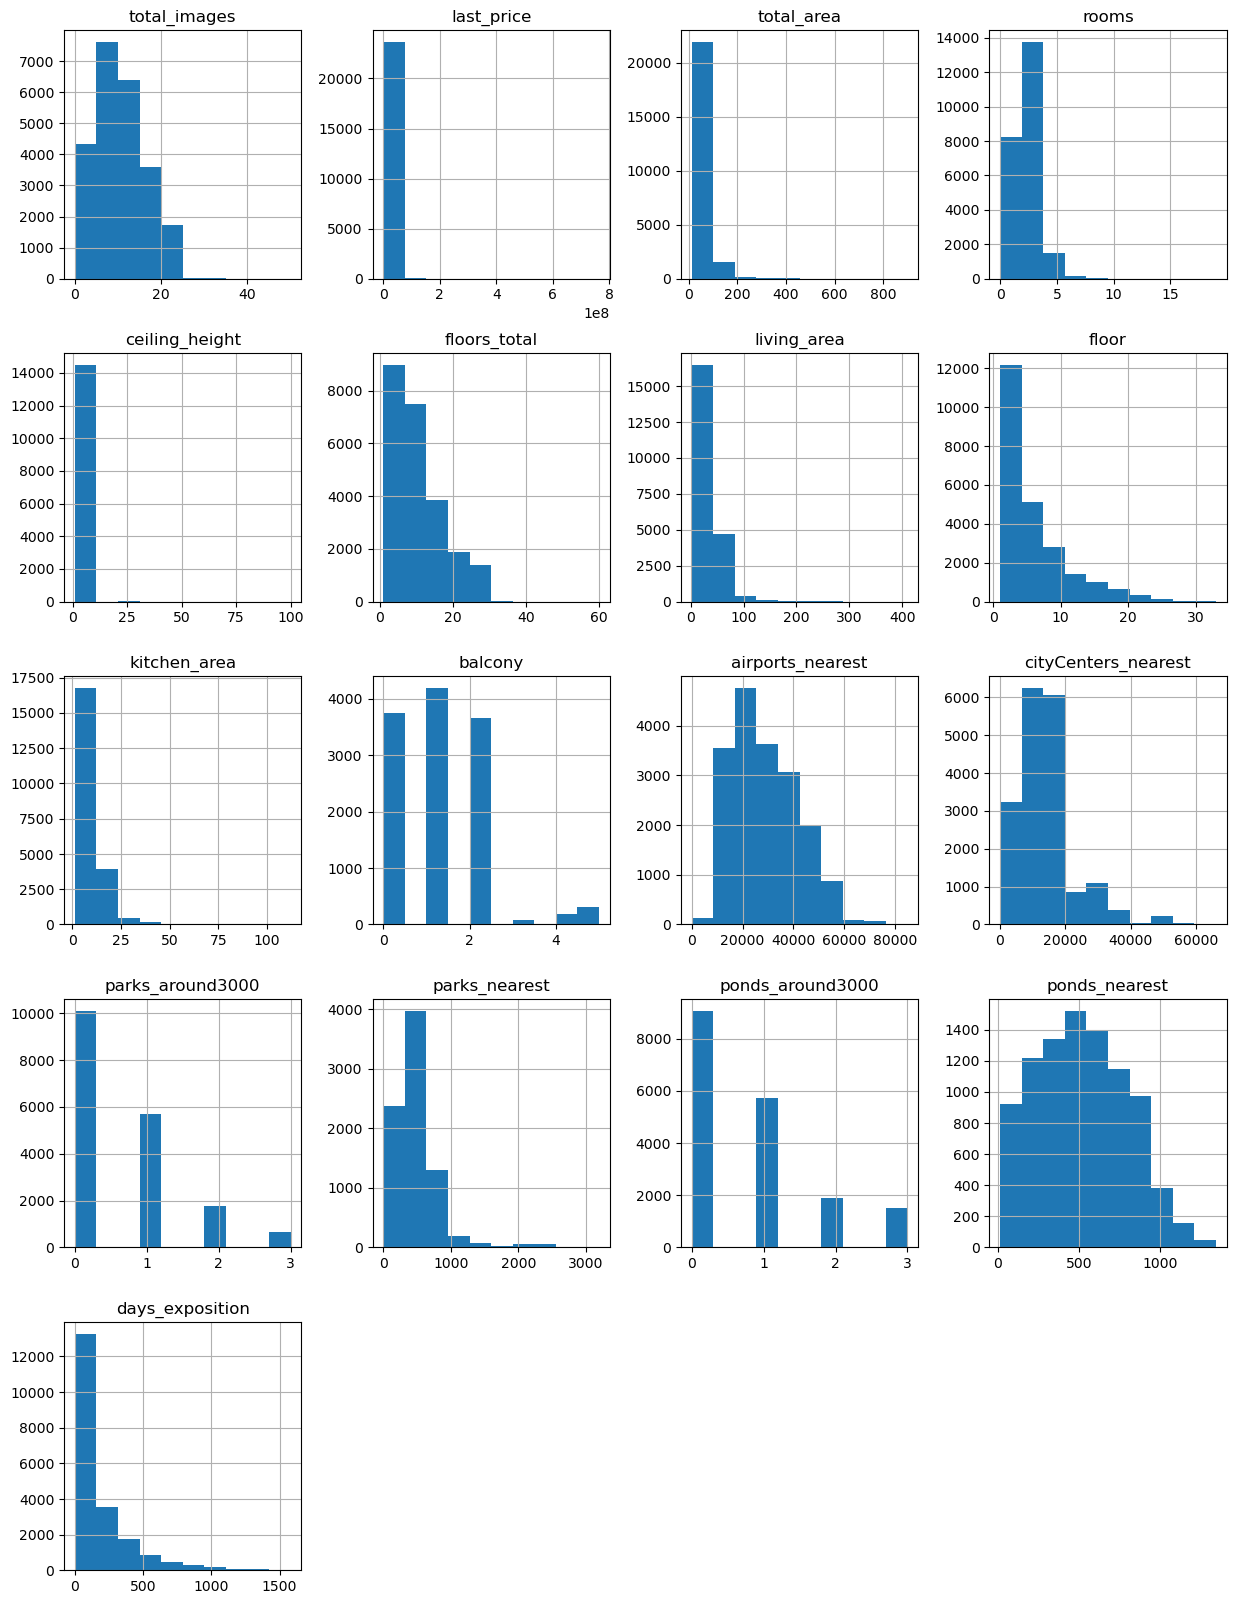

In [3]:
data.hist(figsize=(15, 20));

Вывод: В данных есть пропуски и выбросы. Их нужно обработать

### Предобработка данных

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Предполагаем, что незаполненные ячейки balcony можно заменить на 0

In [5]:
data['balcony'] = data['balcony'].fillna(0)

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Возможные причины пропусков:
* Владелец мог не указать данные, если параметр отсутствует у квартиры
* Владелец мог внести символ, который не был считан системой сбора данных
* Просто ошибка составителя таблицы
* Повреждение данных при переносе

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [8]:
print(data['rooms'].unique())
print(data['floor'].unique())
print(data['is_apartment'].unique())
print(data['balcony'].unique())
print(data['parks_around3000'].unique())
print(data['ponds_around3000'].unique())
print(data['days_exposition'].unique())

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
[ 8  1  4  9 13  5  6 22 26  7  3  2 11 15 18 10 19 16 20 27 25 17 14 12
 21 28 24 23 30 29 32 33 31]
[nan False True]
[0. 2. 1. 5. 4. 3.]
[ 1.  0.  2. nan  3.]
[ 2.  0.  3.  1. nan]
[  nan   81.  558. ... 1360. 1007.  971.]


Уберем пропуски в данных

In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [10]:
#print(data['ceiling_height'].head())

Заменим пропущенные значения на медианные

Сначала нужно убрать неявные дубли в локациях

In [11]:
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок ', '')
data['locality_name'] = data['locality_name'].str.replace('деревня ', '')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ', '')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ', '')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ', '')
data['locality_name'] = data['locality_name'].str.replace('станции ', '')
data['locality_name'] = data['locality_name'].str.replace('село Павлово', 'Павлово')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной Приветнинское', 'Приветнинское')
data['locality_name'] = data['locality_name'].str.replace('Старая', 'деревня Старая')
data['locality_name'] = data['locality_name'].str.replace('имени Свердлова', 'пгт имени Свердлова')

In [12]:
for element in data['locality_name'].unique():
    data.loc[(data['locality_name'] == element) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['locality_name'] == element), 'ceiling_height'].mean()
    
print(data['ceiling_height'].isna().sum())

131


In [13]:
for element in data['locality_name'].unique():
    data.loc[(data['locality_name'] == element) & (data['floors_total'].isna()), 'floors_total'] = \
    data.loc[(data['locality_name'] == element), 'floors_total'].mean()
    
print(data['floors_total'].isna().sum())

1


In [14]:
for index in range(len(data['floors_total'])):
    if data['floors_total'][index] < data['floor'][index]:
        data['floors_total'][index] = data['floor'][index]

In [15]:
for index in range(len(data['floors_total'])):
    if data['floors_total'][index] < data['floor'][index]:
        print('Something is wrong')
else:
    print('All good')

All good


In [16]:
for element in data['total_area'].unique():
    data.loc[(data['total_area'] == element) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area'] == element), 'kitchen_area'].mean()
    
print(data['kitchen_area'].isna().sum())

205


In [17]:
for element in data['locality_name'].unique():
    data.loc[(data['locality_name'] == element) & (data['ponds_around3000'].isna()), 'ponds_around3000'] = \
    data.loc[(data['locality_name'] == element), 'ponds_around3000'].mean()
    
print(data['ponds_around3000'].isna().sum())

4837


In [18]:
for element in data['locality_name'].unique():
    data.loc[(data['locality_name'] == element) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == element), 'airports_nearest'].mean()
    
print(data['airports_nearest'].isna().sum())

4837


In [19]:
for room_number in data['rooms'].unique(): 
    data.loc[(data['rooms'] == room_number) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == room_number), 'living_area'].median()
    
print(data['living_area'].isna().sum())

0


In [20]:
columns_to_mean = [
    
    'ceiling_height'
]


for element in columns_to_mean: 
    data[element] = data[element].fillna(data[element].median())


locality_name и is_apartment заменим на unknown

In [21]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [22]:
data['locality_name'] = data['locality_name'].fillna('unknown')
data['is_apartment'] = data['is_apartment'].fillna('unknown')

In [23]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                1
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              205
balcony                     0
locality_name               0
airports_nearest         4837
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         4837
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23494 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Тип данных rooms, floor, balcony, parks_around, ponds_around, days_exposition и др. нужно исправить на int.
Тип данных is_apartment нужно исправить на bool.
Менять нужно, потому что данные не соответстыуют указанным типам, что может вызвать ошибки при вычислениях

In [25]:
data['total_images'] = data['total_images'].astype('int')
data['rooms'] = data['rooms'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int32  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int32  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23494 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [26]:
locality_list = list(data['locality_name'].unique())

In [27]:
pivot_by_locality = data.pivot_table(index='locality_name', values='airports_nearest', aggfunc = 'median')
pivot_by_locality.columns=['median']

In [28]:
print(data['airports_nearest'].isna().sum())

4837


Обработка аномальных данных

In [29]:
print(data['ceiling_height'].unique())

[  2.7          2.64447005   2.80370942   3.03         2.63275862
   2.63029197   2.9054386    2.5          2.67         2.60472527
   2.65930693   2.56         2.70666667   3.05         2.75
   2.6          2.9          2.6280303    2.8          2.61142857
   2.55         3.           2.65         2.78194631   3.2
   2.6145614    2.61588235   2.61         2.52777778   2.53333333
   2.65366667   2.72877551   2.71666667   3.25         3.45
   2.77         2.85         2.56666667   2.64         2.57
   4.15         3.5          2.51666667   3.3          2.71
   4.           2.47         2.565        2.73         2.84
   3.1          2.71608696   2.675625     2.34         3.4
   2.57857143   2.5675       3.06         2.72         2.56821429
   2.54         2.51         2.62537931   2.78         4.105625
   2.72527132   2.76         2.71625641   2.70958763  25.
   2.58         3.7          2.62631579   2.64116279   2.57078431
   2.52         2.63181818   5.2          2.60714286   2.475
   

In [30]:
data.loc[(data['ceiling_height'] > 9.0), 'ceiling_height'] = data.loc[(data['ceiling_height'] > 9.0), 'ceiling_height'] / 10
#print(data['ceiling_height'].unique())

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int32  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int32  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23698 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23494 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Проверяем данные на выбросы

In [32]:
list_columns = list(data)

In [33]:
def description(column):
    return data[column].describe()
description(list_columns)


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23698.000000,23699.000000,23699.000000,23494.000000,23699.000000,18862.000000,18180.000000,18181.000000,8079.000000,18862.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.742282,10.684776,34.321982,5.892358,10.516504,0.591080,29540.200945,14191.277833,0.611408,490.804555,0.807583,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.247066,6.592705,21.700627,4.885249,5.788179,0.959298,13062.975489,8608.386210,0.802074,342.317995,0.946227,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.100000,0.000000,18846.750000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.716667,9.000000,30.300000,4.000000,9.155680,0.000000,27362.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.803709,16.000000,42.700000,8.000000,11.900000,1.000000,38755.500000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,10.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Стоит наверное удалить огромную квартиру и огромные этажи


In [34]:
data['floors_total'] = data['floors_total'].loc[data['floors_total'] <40]

<AxesSubplot:>

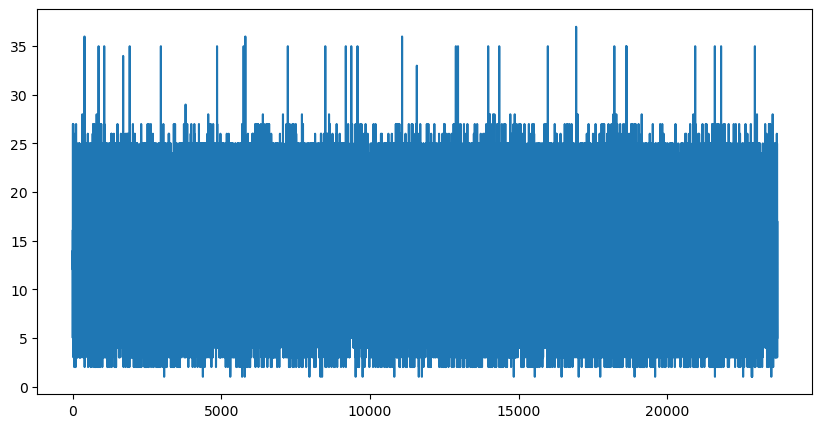

In [35]:
data['floors_total'].plot(figsize=(10,5))

<AxesSubplot:>

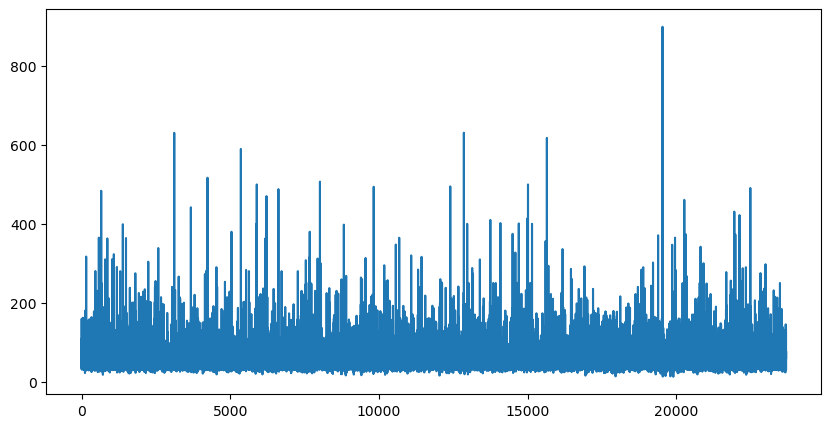

In [36]:
data['total_area'].plot(figsize=(10,5))

In [37]:
print(data.loc[data['total_area'] == 900])

       total_images   last_price  total_area first_day_exposition  rooms  \
19540             8  420000000.0       900.0  2017-12-06T00:00:00     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
19540             2.8          25.0        409.7     25          True  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
19540         112.0        0  Санкт-Петербург           30706.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19540              7877.0               0.0            NaN               2.0   

       ponds_nearest  days_exposition  
19540          318.0            106.0  

[1 rows x 22 columns]


Квартира 900 м.кв. вполне реалистична. Цена и количество комнат соответствуют площади. Но, все равно это выброс.

In [38]:
data['total_area'] = data['total_area'].loc[data['total_area'] <899]

<AxesSubplot:>

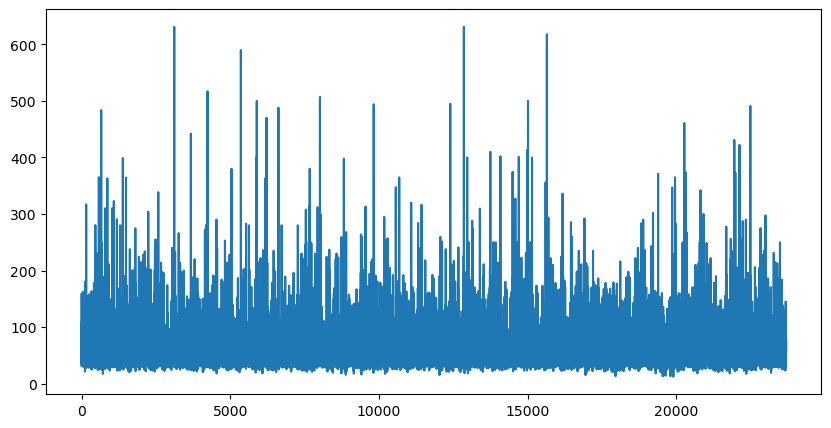

In [39]:
data['total_area'].plot(figsize=(10,5))

Проверим, нет ли нереалистично маленьких квартир с большим количеством комнат.

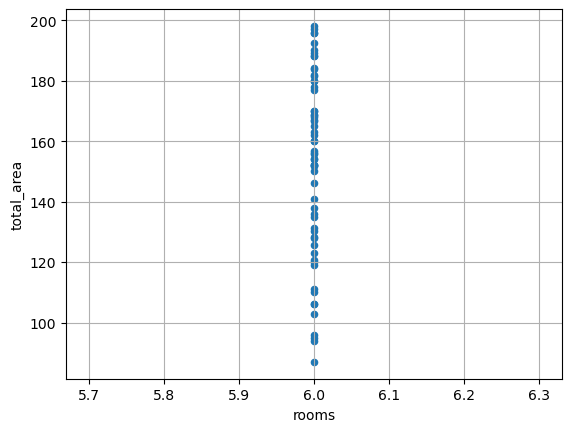

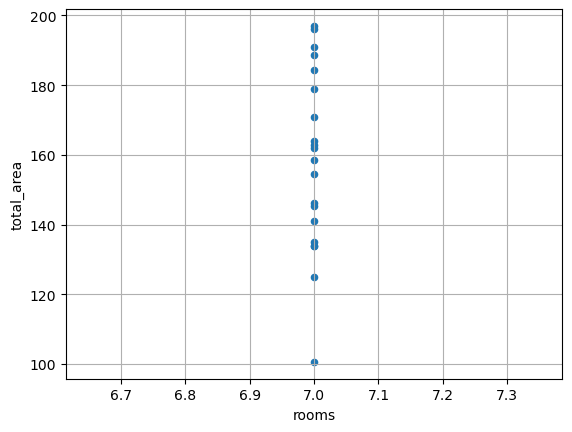

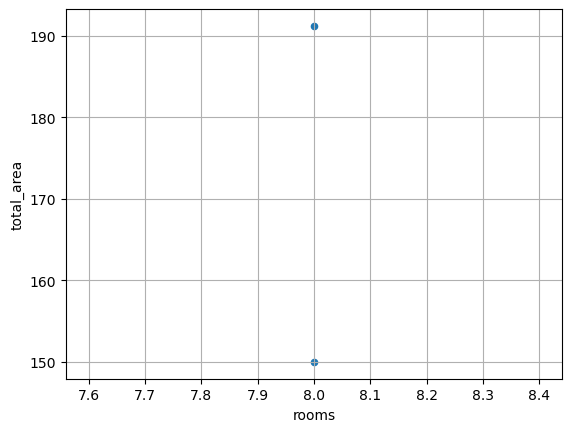

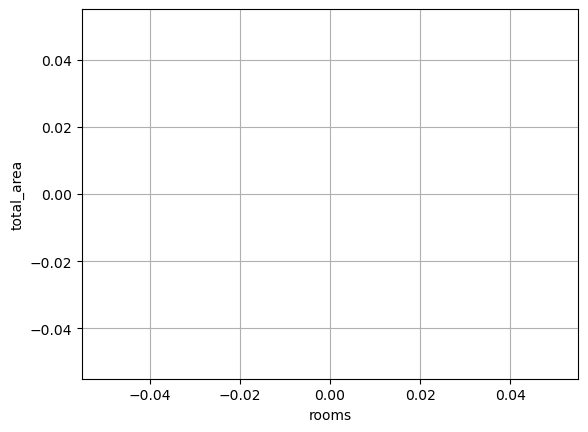

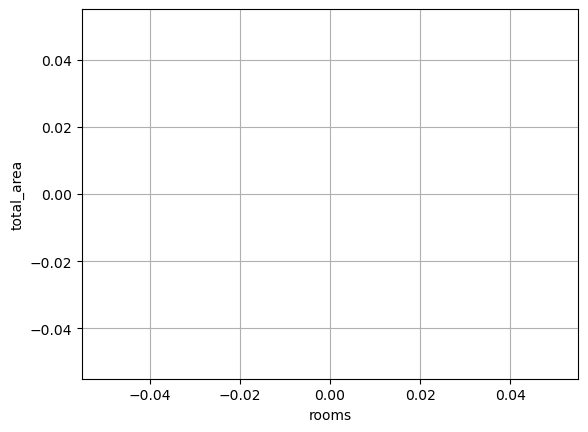

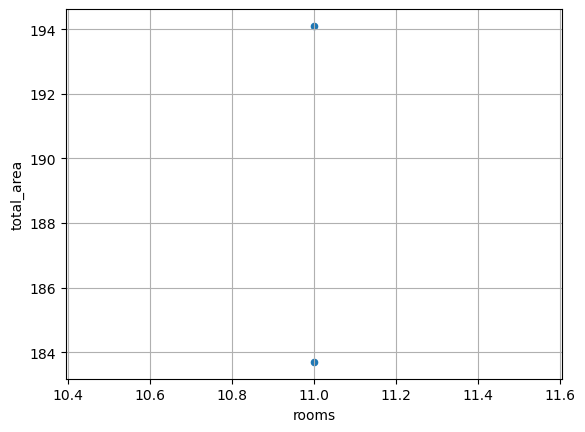

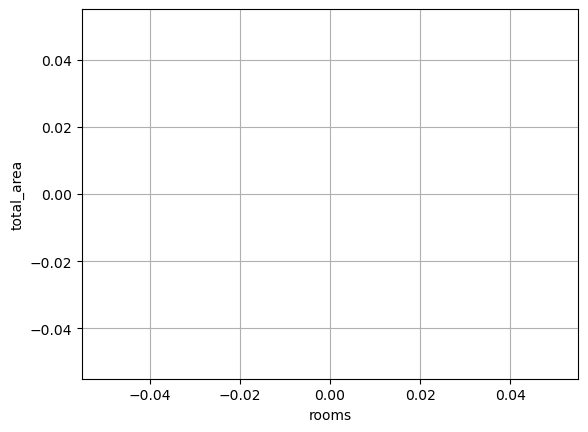

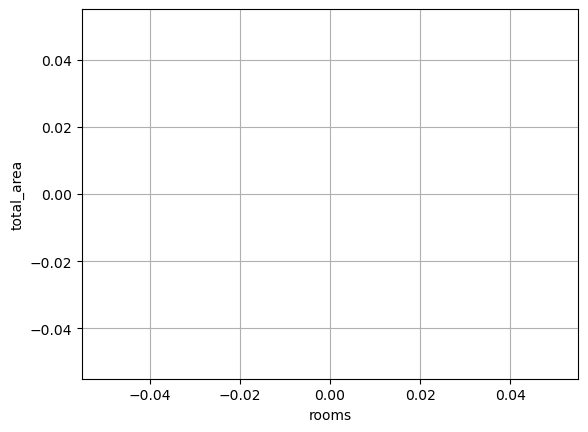

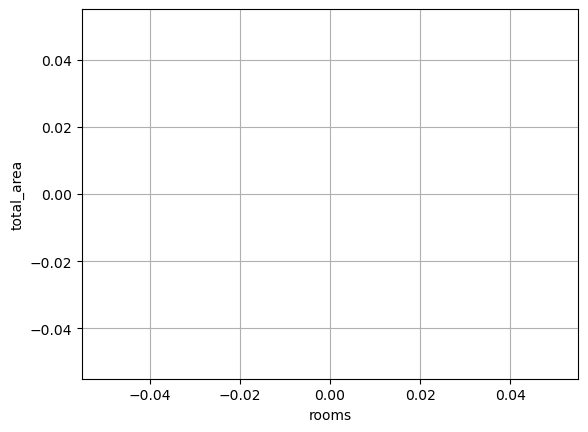

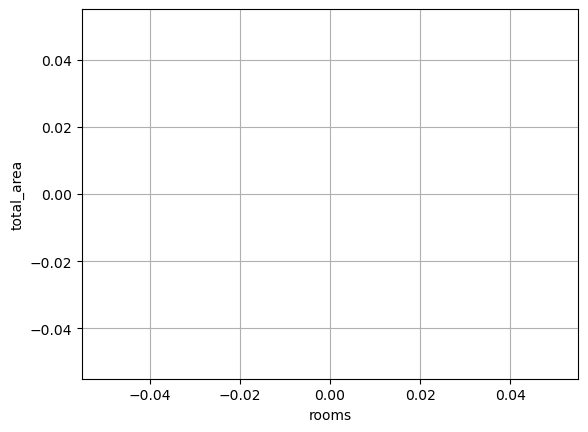

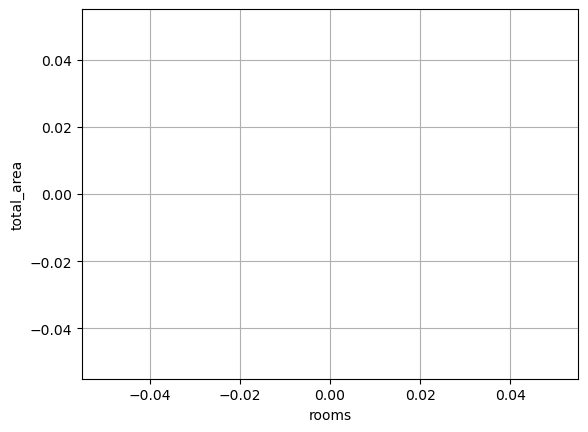

In [40]:
data['rooms'].unique()
n_rooms = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for room in n_rooms:
    data.loc[(data['rooms'] == room) & (data['total_area'] < 200)].plot(x='rooms', y='total_area', kind='scatter', grid=1)


Выглядит не вполне логично но в принципе возможно, 6 комнатные квартиры начинаются от 80 метров кв.

Проверим, соотвествуют ли размеры living_area и kitchen_area площади квартиры

In [41]:
for index in range(len(data['total_area'])):
    if data['total_area'][index] < data['kitchen_area'][index]:
        print('Something is wrong')
else:
    print('All good')

All good


Проверим соответствие living_area и total_area

<AxesSubplot:xlabel='living_area', ylabel='total_area'>

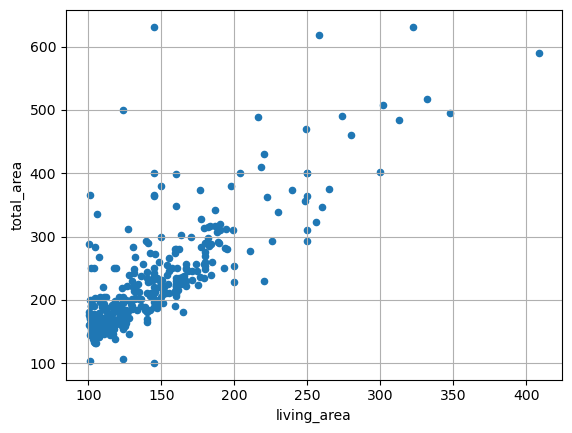

In [42]:
area_unique = data.query('living_area > 100')
area_unique.plot(x='living_area', y='total_area', kind='scatter', grid=1)

Получили много столбцов, где living_area > total_area из-за заполнения пропусков медианой living_area. Поэтому, для этих значений living_area был заменен на 80% от total_area.

In [43]:
for index in range(len(data['total_area'])):
    if data['total_area'][index] < data['living_area'][index]:
        data['living_area'][index] = 0.8*data['total_area'][index]


In [44]:
for index in range(len(data['total_area'])):
    if data['total_area'][index] < data['living_area'][index]:
        print('Something is wrong')
else:
    print('All good')

All good


In [47]:
old_data = pd.read_csv(r'D:\Main\Yandex Practicum\Y.Anal\Project Research Data Analysis\real_estate_data.csv', sep='\t')

In [48]:
print(data['living_area'].shape[0]/old_data['living_area'].shape[0])

1.0


Вывод:
На данном этапе удалось заполнить некоторые пропуски, изменить тип данных в некоторых столбцах, устранить дубликаты в названиях населенных пунктов, исправить аномалии в некоторых столбцах.

### Посчитайте и добавьте в таблицу новые столбцы

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int32  
 1   last_price            23699 non-null  float64
 2   total_area            23698 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int32  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23696 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23494 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Определим цену за м.кв

In [50]:
data['meter_price'] = data['last_price']/data['total_area']
#print(data['meter_price'].head())
#print(data['last_price'].head())

In [51]:
data['first_day_exposition'].head()

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

Приведем время к формату datetime

In [52]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

Создадим новые столбцы по дням, месяцам, годам

In [53]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Создадим столбец расстояния до центра в км

In [54]:
data['cityCenters_km'] = data['cityCenters_nearest']/1000
np.ceil(data['cityCenters_km'])

0        17.0
1        19.0
2        14.0
3         7.0
4         9.0
         ... 
23694     5.0
23695     NaN
23696     NaN
23697    11.0
23698     NaN
Name: cityCenters_km, Length: 23699, dtype: float64

Создание столбца с названием этажа

In [55]:
def floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']

    if floor == floors_total:
        return 'последний'

    if floor == 1:
        return 'первый'

    return 'другой'

data['floor_type'] = data.apply(floor_category, axis=1)

In [56]:
#код ревьюера
data['floor_type'].value_counts()

другой       17417
последний     3390
первый        2892
Name: floor_type, dtype: int64

In [57]:
#data.info()

Вывод: На данном этапе были созданы новые столбцы, необходимые для последующего анализа.

### Проведите исследовательский анализ данных

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  float64       
 2   total_area            23698 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23696 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23494 non-null  float64       
 13  balcony         

Выведем гистограмы по необходимым столбцам.

<AxesSubplot:>

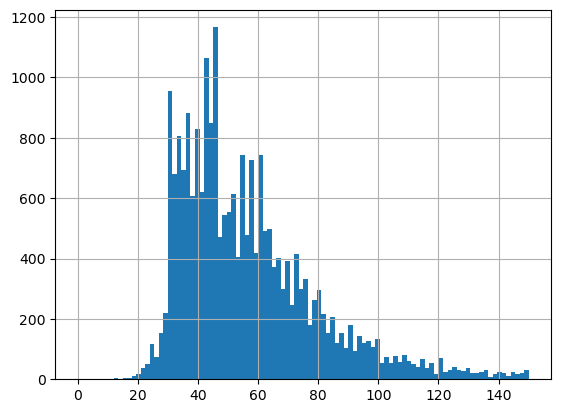

In [59]:
data['total_area'].hist(bins=100, range = (0, 150))

Большинство квартир 30-70 м.кв.

<AxesSubplot:>

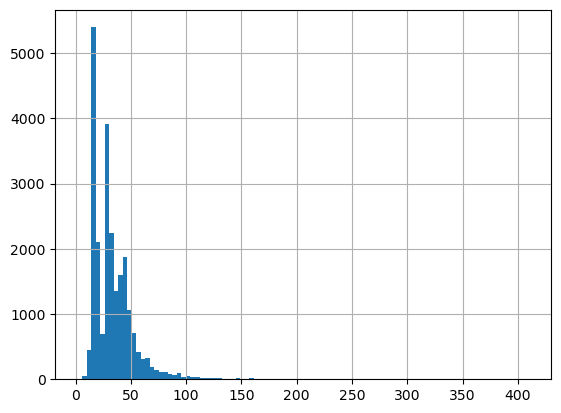

In [60]:
data['living_area'].hist(bins=100)

Жилая площадь соответсвует общей

<AxesSubplot:>

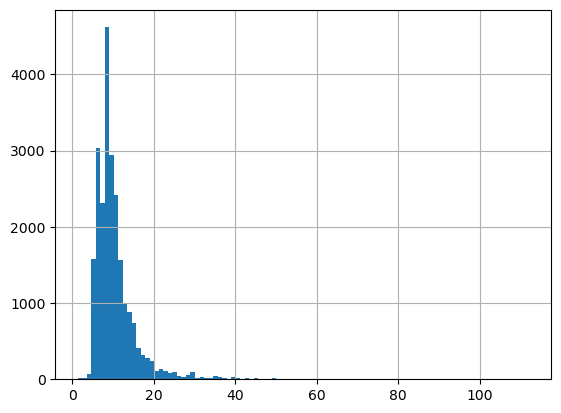

In [61]:
data['kitchen_area'].hist(bins=100)

Кухонная площадь соответсвует общей

last_price_mill = data['last_price'].div(1000000)
last_price_mill.hist(bins=100, range = (0, 25))

<AxesSubplot:>

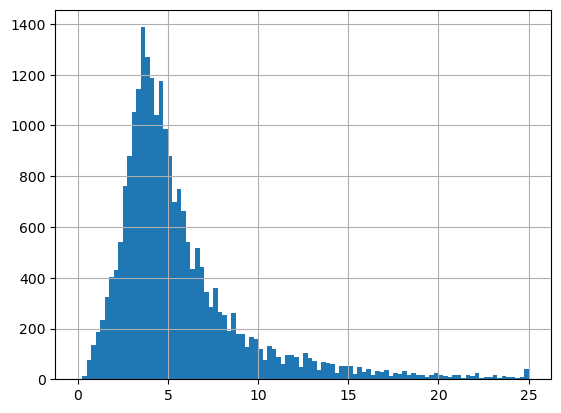

In [62]:
last_price_mill = data['last_price'].div(1000000)
#data['last_price'].hist(bins=100, range = (0, 25000000))
last_price_mill.hist(bins=100, range = (0, 25))

In [63]:
print(data['last_price'].head())

0    13000000.0
1     3350000.0
2     5196000.0
3    64900000.0
4    10000000.0
Name: last_price, dtype: float64


График цены сообщает о том, что большинство квартир стоят около 4 млн рублей

[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]


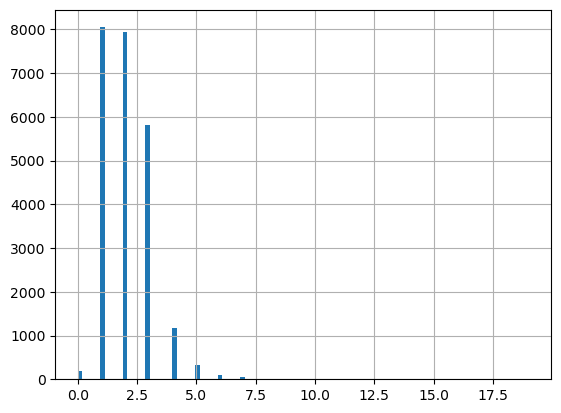

In [64]:
data['rooms'].hist(bins=100)
print(data['rooms'].unique())

Большинство квартир имеют от 1 до 3 комнат. Квартиры с 0 комнатами, вероятно, студии

<AxesSubplot:>

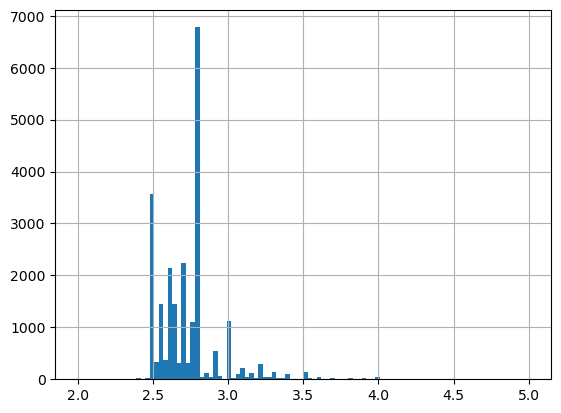

In [65]:
data['ceiling_height'].hist(bins=100, range = (2,5))
#print(sorted(data['ceiling_height'].unique()))

У большинства квартир потолок от 2.4 до 3 метров включительно

<AxesSubplot:>

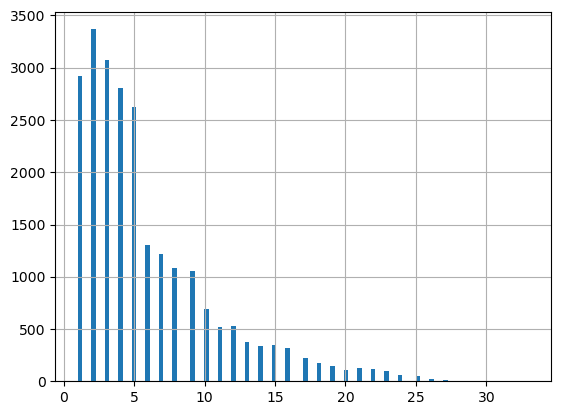

In [66]:
data['floor'].hist(bins=100)

Большинство квартир от 1 до 5 этажа

<AxesSubplot:>

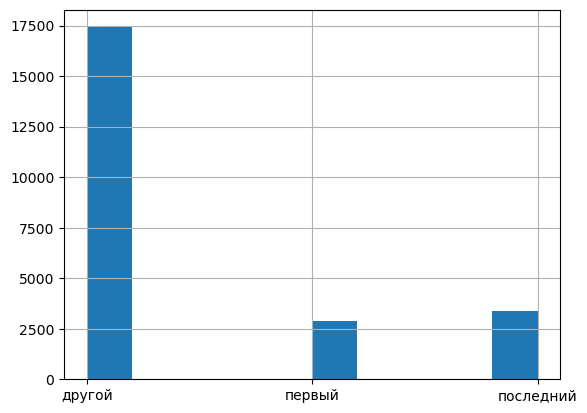

In [67]:
data['floor_type'].hist()

Большинство квартир между первым и последним этажем

<AxesSubplot:>

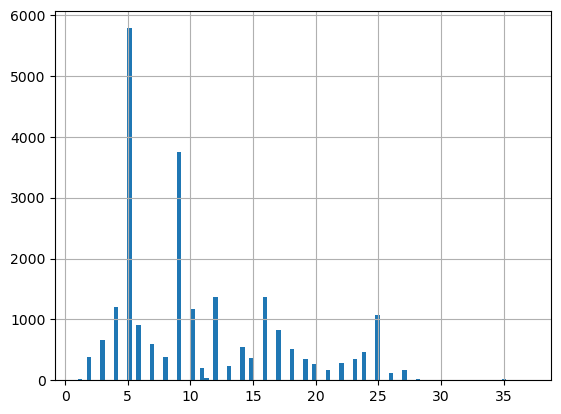

In [68]:
data['floors_total'].hist(bins=100)

Есть два пика: пятиэтажки и девятиэтажки

<AxesSubplot:>

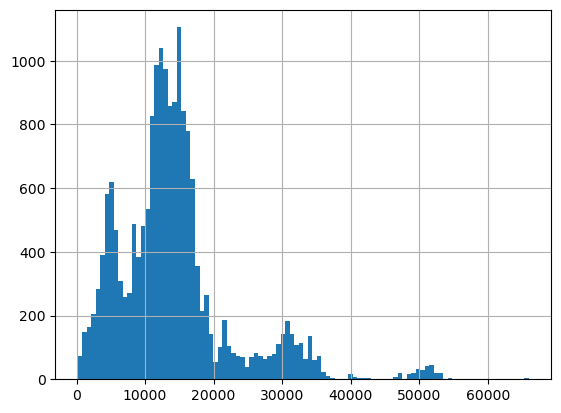

In [69]:
data['cityCenters_nearest'].hist(bins=100)

Большинство квартир находятся на расстоянии в 10-18 км от центра.

<AxesSubplot:>

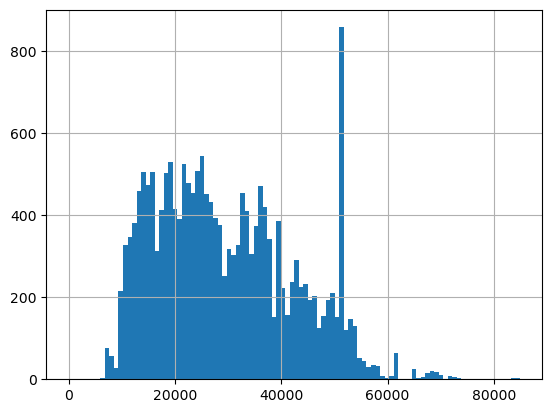

In [70]:
data['airports_nearest'].hist(bins=100)

Большинство квартир находятся на расстоянии минимум в 10 км от аэропорта. Но еще есть выброс, созданный мной, похоже.

<AxesSubplot:>

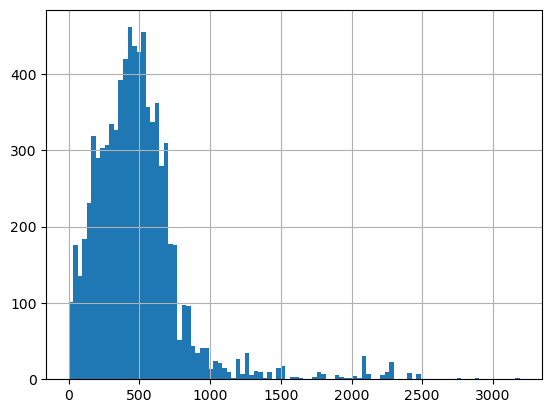

In [71]:
data['parks_nearest'].hist(bins=100)

Большинство квартир находятся на расстоянии около 300 - 750 м от парка.

<AxesSubplot:>

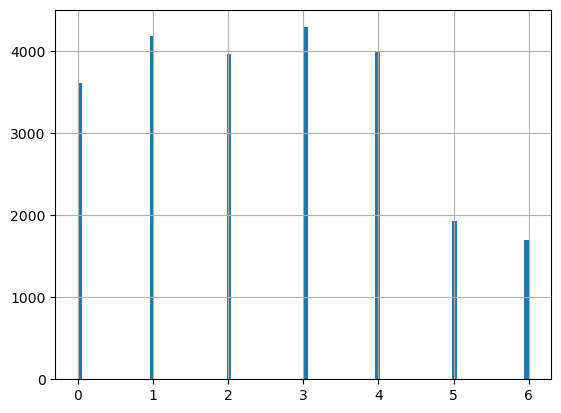

In [72]:
data['weekday'].hist(bins=100)

Квартиры реже выкладывают на выходных

<AxesSubplot:>

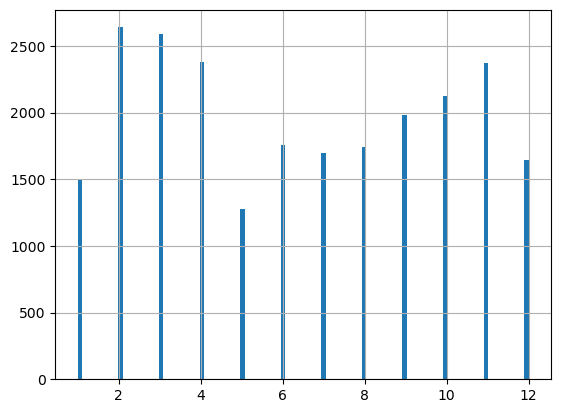

In [73]:
data['month'].hist(bins=100)

В декабре-январе и в мае(видимо из-за праздников) квартиры выкладывают реже. Февраль-апрель самое активное время

Изучим длительность продажи квартиры

In [74]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

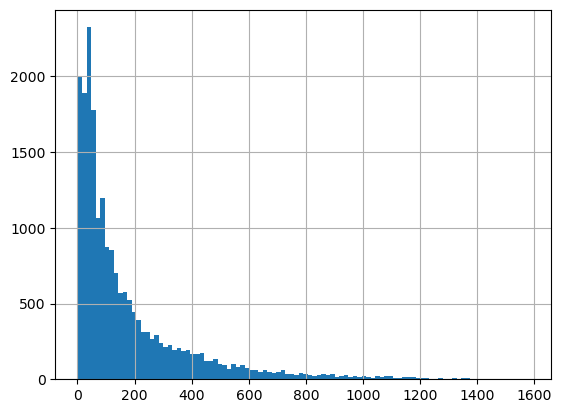

In [75]:
data['days_exposition'].hist(bins=100)

Медиана 95, среднее 180. Значит, в средннем квартиру продают за 95 дней, но есть много квартир, которые долго ждут своего часа. Быстрые продажи - быстрее 95 дней, долгие - дольше.

Исследуем зависимость цены от параметров квартиры

0.6431493531735252


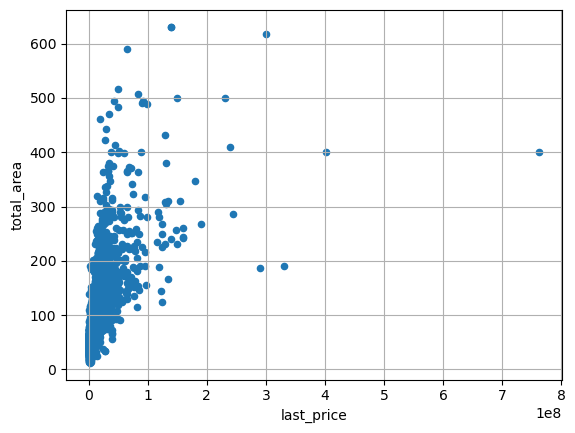

In [76]:
print(data['total_area'].corr(data['last_price']))
data.plot(x='last_price', y='total_area', kind='scatter', grid=1);

0.5568795709657635


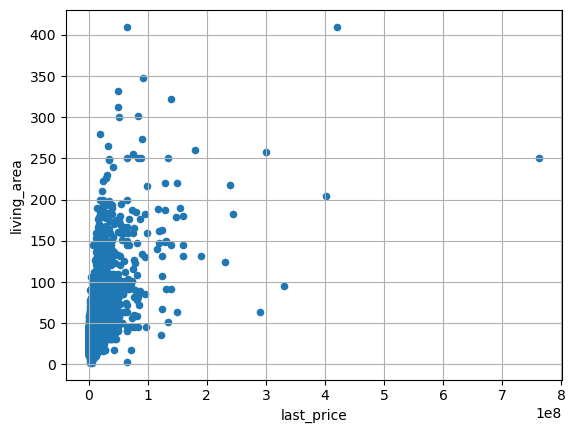

In [77]:
print(data['living_area'].corr(data['last_price']))
data.plot(x='last_price', y='living_area', kind='scatter', grid=1);

0.4891714401485181


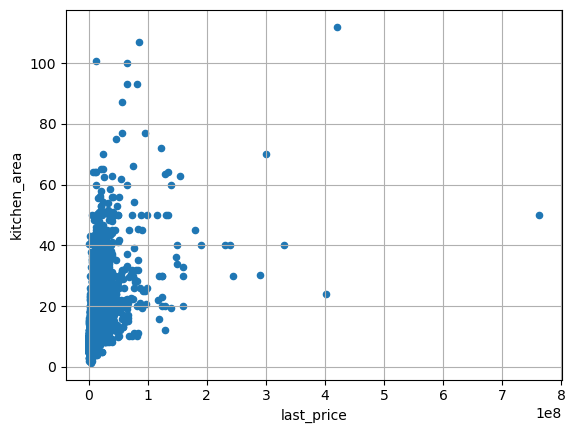

In [78]:
print(data['kitchen_area'].corr(data['last_price']))
data.plot(x='last_price', y='kitchen_area', kind='scatter', grid=1);

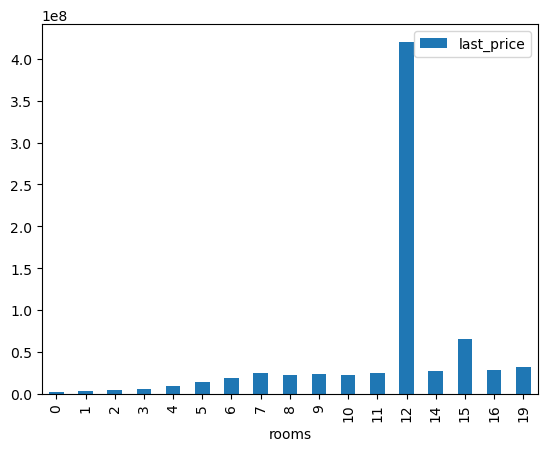

In [79]:
pivot_median_data = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
pivot_median_data.plot.bar();

Первые 4 фактора оказывают наибольшее положительное влияние на цену. Остальные - незначительное положительное, кроме year: влияение года незначительное но отрицательное (чем старее квартира тем дешевле)

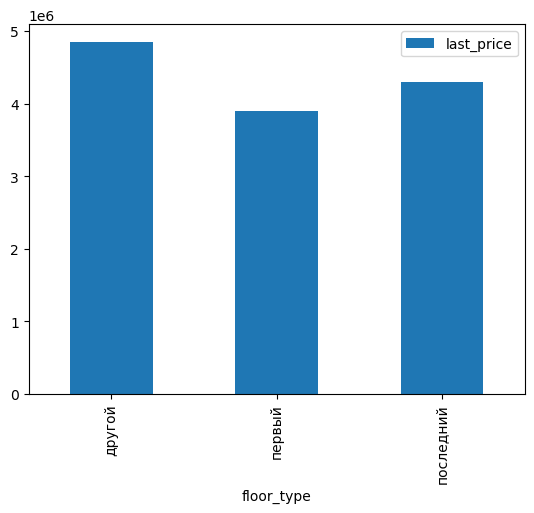

In [80]:
pivot_median_data = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
pivot_median_data.plot.bar();

Квартиры на первом и последнем этажах, в среднем, дешевле остальных.

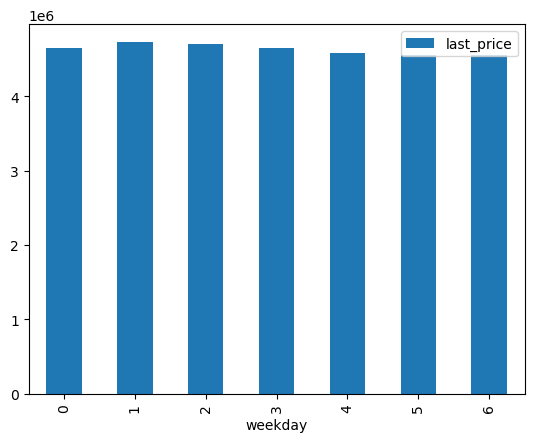

In [81]:
pivot_median_data = data.pivot_table(index='weekday', values='last_price', aggfunc='median')
pivot_median_data.plot.bar();

Квартиры выложенные в разные дни в среднем не отличаются по стоимости

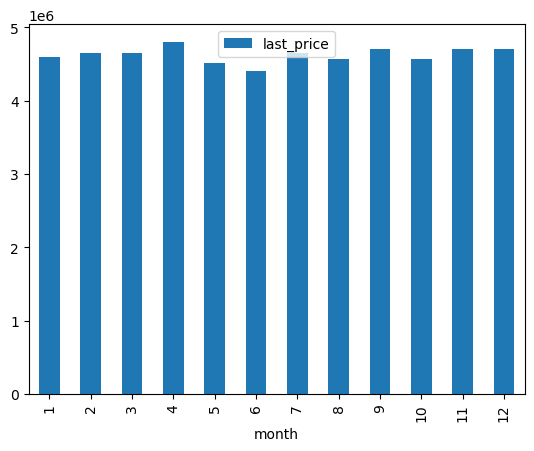

In [82]:
pivot_median_data = data.pivot_table(index='month', values='last_price', aggfunc='median')
pivot_median_data.plot.bar();

Квартиры выкладваемые в мае-июне стоят дешевле. Видимо, сезонность спроса

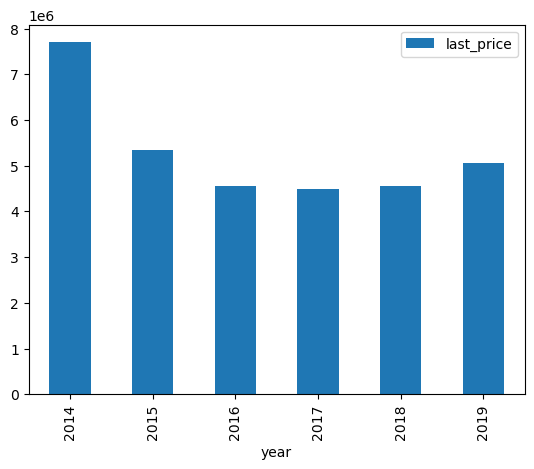

In [83]:
pivot_median_data = data.pivot_table(index='year', values='last_price', aggfunc='median')
pivot_median_data.plot.bar();

В 14 году цены на жилье сильно выросли из-за инфляции около 20%, в связи с некоторыми событиями. Оценивать данные без поправки на ключевую ставку нелогично. С 2015 по 2019 ставка менялась с 11% до 6%, однако даже при падающей ставке цены росли с 2017 по 2019 год. 

Найдем топ 10 городов по количеству объявлений

In [84]:
df_by_locality = data.pivot_table(index='locality_name', values='meter_price', aggfunc = ['sum', 'count', 'mean'])
df_by_locality.droplevel(1, axis=1)
df_by_locality.columns=['sum', 'count', 'mean']
df_by_locality = df_by_locality.sort_values(by=['count'], ascending=False)
print(df_by_locality.head(10))

                          sum  count           mean
locality_name                                      
Санкт-Петербург  1.805075e+09  15720  114826.628536
Мурино           5.079163e+07    590   86087.512050
Кудрово          4.499337e+07    472   95324.930544
Шушары           3.461804e+07    440   78677.364217
Всеволожск       2.732448e+07    398   68654.473986
Пушкин           3.805343e+07    369  103125.819291
Колпино          2.549351e+07    338   75424.579098
Парголово        2.948752e+07    327   90175.913458
Гатчина          2.110507e+07    307   68746.146763
Выборг           1.377963e+07    237   58141.909153


Средняя цена за метр.кв. похожа на правду судя по гуглу. Самый дорогой метр в СПБ 114827 р, самый дешевый в Выборге 58142 р

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  float64       
 2   total_area            23698 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23696 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23494 non-null  float64       
 13  balcony         

Посмотрим как цена зависит от удаленности от центра в спб

-0.2595074646319884


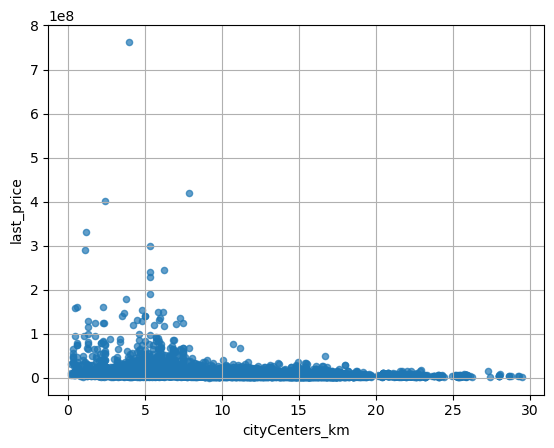

In [86]:
spb_data = data.query('locality_name == "Санкт-Петербург"')
print(spb_data['last_price'].corr(spb_data['cityCenters_km']))
spb_data.plot(x='cityCenters_km', y='last_price', kind='scatter', alpha=0.7, grid=1);

In [87]:
spb_mean_per_km = spb_data['last_price'].mean()/spb_data['cityCenters_km'].mean()
print(spb_mean_per_km)

694966.3336512313


В среднем, 1 км стоит 694618 р. Чем ближе к центру тем дороже недвижимость, поскольку коэффикиент корреяции отрицательный. В идеале, нужно разбить расстояния до центра на группы и посмотреть как сильно влияет расстояние до центра внутри них, ведь 1 дополнительный километр может не играть никакой роли если дом и так в 20 км от центра. Центр заканчивается на 8 километре, поскольку заканчиваются дорогие редкие квартиры, а на 11-12 километре возможно есть какой-то дорогой район пригорода

### Общий вывод

Из интересных особенностей и зависимостей на рынке недвижимости можно выделить следующие:<br>

Характеристики типичной квартиры:
* Площадь от 30 до 70 метров
* 1-3 комнаты
* 2.4-3 м потолки
* Располагается на 1-5 этаже
* В 5 или 9 этажной квартире
* Примерно в 10-18 км от центра города
* Минимум в 10 км от аэропорта
* В 300-750 м от парка.<br>

Цена и продажа:
* Квартиры реже выкладывают на выходных и в праздничные месяцы (декабрь, январь, май)
* Самое активное время для публикации квартир – февраль-апрель
* Квартиры продаются в среднем за 95 дней, но есть и те, кто долго ждут продажи, поскольку среднее значение - 180 дней.🆕
* В среднем, квартиры стоят около 5 млн. руб.
* На цену сильнее всего положительно влияют общая площадь квартиры (коэф.корр. 0.64), площадь жилого пространства (0.56), площадь кухни (0.44), количество комнат (0.4). Отрицательно влияет год постройки (-0.04): чем старее дом, тем дешевле.<br><br>
* Дешевле всего квартиры выкладывают в мае-июне 🆕
* В 14 году цены на жилье сильно выросли из-за инфляции около 20%, в связи с некоторыми событиями. Оценивать данные без поправки на ключевую ставку нелогично. С 2015 по 2019 ставка менялась с 11% до 6%, однако даже при падающей ставке цены росли с 2017 по 2019 год. 🆕

Количество объявлений, цена за м.кв и км. от центра:
* Из нашего списка больше всего объявлений в Санкт-Петербурге (15720 объявлений).
* Остальные топ 9 населенных пунктов имеют в среднем 350 объявлений.
* При этом самый дорогой метр квадратный в СПБ 114827 р, самый дешевый в Выборге 58142 р.
* В среднем, 1 км приближенности к центру стоит 694618 р. Чем ближе к центру тем дороже недвижимость.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод